#### Laurent Jutras-Dubé

## Hopf scenario of Fig. 1

####   

**1. Pattern formation with the Hopf scenario**

In this notebook, we study the Hopf model used to generate the results of Fig. 1 G-K. It is the clock and wavefront model evolved _in silico_ in the following paper:

François, P., Hakim, V., & Siggia, E. D. (2007). Deriving structure from evolution: metazoan segmentation. *Molecular systems biology*, 3(1).

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.animation import (FuncAnimation, writers)
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 0})

####    

**1.1 The ODEs**

In the following code cell, we define functions for the ODEs describing the time evolution of the two proteins involved in the system: the effector protein $E$ and the repressor protein $R$. The ODEs are the following:

\begin{align}
\dot{E} &= \Bigg( \max \Bigg[ \frac{E^{n_1}}{E^{n_1} +E_E^{n_1}} \: \: , \: \frac{g^{n_2}}{g^{n_2} +g_E^{n_2}} \Bigg] \: \: \frac{S_E}{1 +(R \: /R_E)^{n_3}} \Bigg)_{t - \tau_E} -\delta_E \: E \\
\dot{R} &= \Bigg( \frac{g^{n_4}}{g^{n_4} +g_R^{n_4}} \: \: \frac{S_R}{1 +(R \: /R_R)^{n_5}} \Bigg)_{t - \tau_R} -\delta_R R
\end{align}

The subscript of a closed parenthesis indicates the time at which the expression inside the parenthesis is evaluated. If no such parenthesis with a subscript is present in a given expression, this expression is evaluated at time $t$. The values of all parameters are specified in a dictionary later in this notebook.

In [2]:
def hill_activation(x, h, n):
    
    return x**n/(x**n+h**n)



def hill_repression(x, h, n):
    
    return 1./(1.+(x/h)**n)



def dconc(conc, delayed_conc_E, delayed_conc_R, param):
    
    E = conc[:,0]
    R = conc[:,1]
    g = conc[:,2]
    
    delayed_E_E = delayed_conc_E[:,0]
    delayed_R_E = delayed_conc_E[:,1]
    delayed_g_E = delayed_conc_E[:,2]
    
    delayed_R_R = delayed_conc_R[:,1]
    delayed_g_R = delayed_conc_R[:,2]
    
    
    S_E = param["S_E"]
    R_E = param["R_E"]
    g_E = param["g_E"]
    E_E = param["E_E"]
    delta_E = param["delta_E"]
    n_1 = param["n_1"]
    n_2 = param["n_2"]
    n_3 = param["n_3"]
    
    S_R = param["S_R"]
    R_R = param["R_R"]
    g_R = param["g_R"]
    delta_R = param["delta_R"]
    n_4 = param["n_4"]
    n_5 = param["n_5"]
    

    dE = ( np.maximum(hill_activation(delayed_E_E, E_E, n_1), hill_activation(delayed_g_E, g_E, n_2))
           *S_E*hill_repression(delayed_R_E, R_E, n_3) -delta_E*E )
    dR = hill_activation(delayed_g_R, g_R, n_4) *S_R*hill_repression(delayed_R_R, R_R, n_5) -delta_R*R

    
    return np.array([dE, dR, np.zeros(param["n_cells"])]).transpose()

####    

**1.2 The spatio-temporal profile of morphogen _g_**

We define a function that computes the spatial profile of morphogen $g$ across the tissue at a given time $t$. In a given cell, the value of $g$ decreases exponentially (via the `s` parameter). To generate a spatial pattern, we make the time at which the value of $g$ starts decreasing, $t^*$, dependent on the position $x$ of the cell in the tissue: $t^*(x)$. To model a tissue growing with a constant speed `v`, we make $t^*(x)$ a linear function of $x$.

In [3]:
def compute_g(t, param):
    
    s = param["s"]    # what's in front of x in the paper
    v = param["v"]    # what's in front of t divided by what's in front of x in the paper
    positions = np.linspace(0., param["n_cells"]-1, param["n_cells"])
    
    g = np.exp(s*(positions -v*t))
    g[g > 1.] = 1.
    
    return g

####  

**1.3 The integration scheme**

We use the Euler integration scheme to perform the integration of the ODEs describing the  model. The `integrate` function takes the dictionary of parameters as an input. The three output matrices, `results`, `g_gradient` and `times_plot`, respectively contain the values of the $E$ and $R$ proteins at all positions for every time point, the spatio-temporal distribution of morphogen $g$ and the array of time points. 

In [4]:
def integrate(param):

    # Set the integration parameters    
    total_t = param["total_t"]
    dt = param["dt"]
    times = np.arange(0., total_t, dt)
    times_plot = [0.]

    n_cells = param["n_cells"]
    conc = np.zeros((n_cells, 3))
    conc[:,2] = compute_g(0., param)
    results = [conc]
    
    tau_E = param["tau_E"]
    tau_R = param["tau_R"]

    
    # Perform the integration
    for t in times[1:]:
        
        delayed_conc_E = np.zeros((n_cells, 3))
        if (t > tau_E):
            delayed_conc_E[:,:] = results[int((t-tau_E)/dt)][:,:]
            
        delayed_conc_R = np.zeros((n_cells, 3))
        if (t > tau_R):
            delayed_conc_R[:,:] = results[int((t-tau_R)/dt)][:,:]
        
        
        conc = conc +dconc(conc, delayed_conc_E, delayed_conc_R, param)*dt
        conc[:,2] = compute_g(t, param)
        conc[conc < 0.] = 0.
        
        results.append(conc)
        times_plot.append(t)
        
        
    # Output the results
    results = np.array(results)
    times_plot = np.array(times_plot)
    
    
    return results, times_plot

####  

**1.4 The kymograph plots**

We visualize the results of the integration with a kymograph where the $x$ axis is time and the $y$ axis is the position of the cell along the tissue. On this kymograph, we represent the concentration of the $E$ protein with a color gradient. We do not represent the concentration of the $R$ protein since it is always equal to 0 in the spatial pattern, and therefore does not provide any positional information.

On the kymograph of the concentration of protein $E$, we plot a line representing the moment at which $g$ starts decreasing for the different positions along the tissue. We also plot a line for the moment at which $g$ reaches a specific values, namely $10^{-8}$. To achieve this, we need to define a function `compute_x` that outputs the position of the cell that has a given value of $g$ at a given time, and a function `compute_t` that outputs the time at which $g$ has a given value at a given position along the tissue.

In [5]:
def compute_x(g, t, param):

    s = param["s"]
    v = param["v"]
    
    return np.log(g)/s +v*t



def compute_t(g, x, param):

    s = param["s"]
    v = param["v"]
    
    return (x -np.log(g)/s)/v



def plot_kymograph(results, times, param):
    
    plt.rcParams["figure.figsize"] = 6.4, 4.8
    fig, ax = plt.subplots()
    
    # Kymograph
    norm = colors.Normalize(vmin=0., vmax=np.amax(results))
    kymo = ax.imshow(results.transpose(), norm=norm, cmap='Blues', aspect='auto')
    
    # Colorbar
    cb = fig.colorbar(kymo, ax=ax, shrink=0.75)
    cb.ax.tick_params(labelsize=24)
    
    # Lines of constant g
    ax.plot(compute_x(1., times, param), color='k', linewidth=4)
    ax.plot(compute_x(1e-8, times, param), color='k', linewidth=4)
    ax.text(compute_t(1., 100, param)/param["dt"]-1300, 100, '$g=1$', color='k', rotation=-58, fontsize=24)
    ax.text(compute_t(1e-8, 100, param)/param["dt"], 100, '$g=10^{-8}$', color='k', rotation=-58, fontsize=24)
    
    # Other plot options
    ax.set_title('$[E](x,t)$', fontsize=32)
    ax.set_xlabel('Time $t$', fontsize=32)
    ax.set_ylabel('Position $x$', fontsize=32)
    ax.set_ylim([param["n_cells"], 0])
    ax.set_xticks([])
    ax.set_yticks([])
    
    fig.show()

####  

**1.5 The dynamics of pattern formation**

We define all the parameters required for the ODEs, for the morphogen gradient and for the integration scheme. We then use the `integrate` function to perform the integration and the `plot_kymograph` function to visualise the results. Finally, we plot the spatio-temporal profile of the morphogen $g$ and the trajectories of representative cells. 

In [6]:
# Set all parameter values
param ={
    
    # ODE parameters
    "S_E"     : 0.7176,
    "R_E"     : 0.4942,
    "g_E"     : 0.0678,
    "E_E"     : 0.3213,
    "tau_E"   : 0.48,
    "delta_E" : 0.8538,
    "n_1"     : 3.,
    "n_2"     : 4.3549,
    "n_3"     : 4.5321,
    
    "S_R"     : 0.9422,
    "R_R"     : 0.1156,
    "g_R"     : 0.5047,
    "tau_R"   : 3.92,
    "delta_R" : 0.9759,
    "n_4"     : 3.2136,
    "n_5"     : 4.5220,
    
    # Morphogen gradient parameters
    "s" : 0.5,
    "v" : 3.,
    
    # Integration parameters
    "total_t" : 100.,
    "dt"      : 0.01,
    "n_cells" : 200
}

<IPython.core.display.Javascript object>


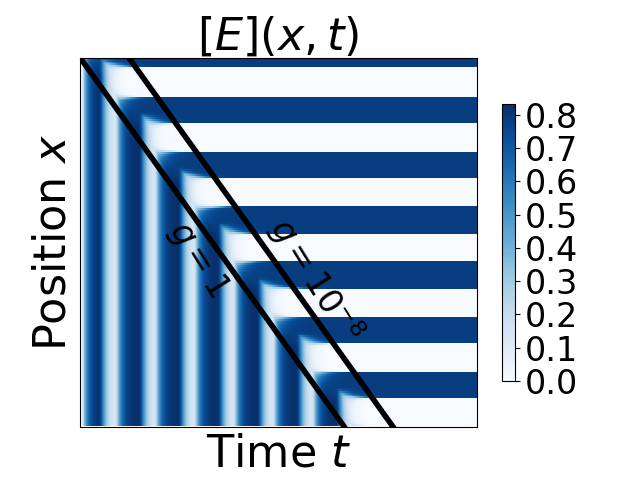

In [7]:
# Perform the integration
results, times_plot = integrate(param)

# Generate the kymograph for E
plot_kymograph(results[:,:,0], times_plot, param)

<IPython.core.display.Javascript object>


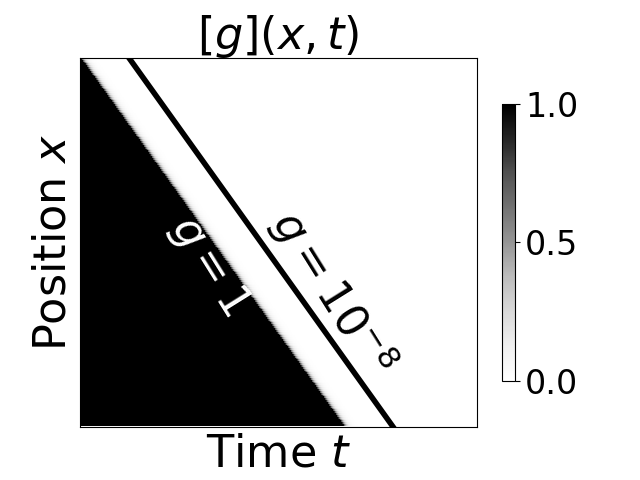

In [8]:
# Generate the kymograph for g
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Kymograph
norm = colors.Normalize(vmin=0., vmax=1.)
kymo = ax.imshow(results[:,:,2].transpose(), norm=norm, cmap='Greys', aspect='auto')
   
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
cb.ax.tick_params(labelsize=24)
  
# Lines of constant g
ax.plot(compute_x(1e-8, times_plot, param), color='k', linewidth=4) 
ax.text(compute_t(1., 100, param)/param["dt"]-1300, 100, '$g=1$', color='w', rotation=-58, fontsize=32)
ax.text(compute_t(1e-8, 100, param)/param["dt"], 100, '$g=10^{-8}$', color='k', rotation=-58, fontsize=32)
    
# Other plot options
ax.set_title('$[g](x,t)$', fontsize=32)
ax.set_xlabel('Time $t$', fontsize=32)
ax.set_ylabel('Position $x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

<IPython.core.display.Javascript object>


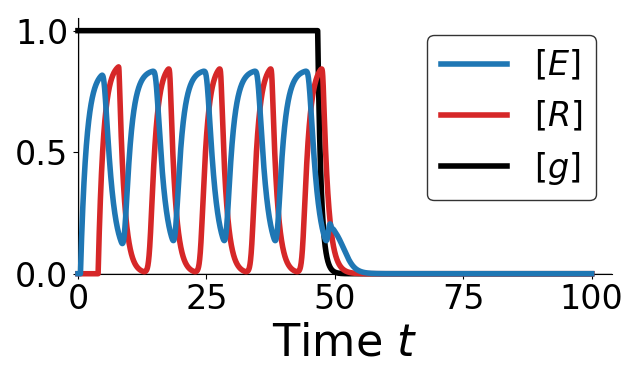

<IPython.core.display.Javascript object>


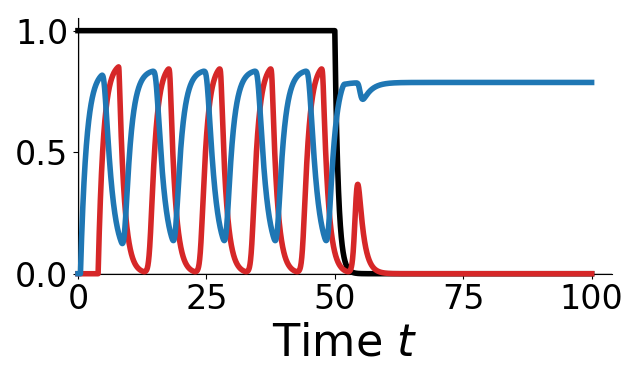

In [9]:
# Plot the first representative trajectory
plt.rcParams["figure.figsize"] = 6.4, 3.8
fig, ax = plt.subplots()
cell1_index = -60

# Effector protein
line_E = ax.plot(times_plot, results[:,cell1_index,0], c='tab:blue', lw=4, label='[$E$]', zorder=10)
line_E[0].set_clip_on(False)

# Repressor protein
line_R = ax.plot(times_plot, results[:,cell1_index,1], c='tab:red', lw=4, label='[$R$]', zorder=9)
line_R[0].set_clip_on(False)

# Morphogen
line_g = ax.plot(times_plot, results[:,cell1_index,2], c='k', lw=4, label='[$g$]', zorder=8)
line_g[0].set_clip_on(False)

# Eliminate upper and right axes
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Other plot options
ax.set_xlabel('Time $t$', fontsize=32)
ax.set_ylim([0.,1.05])
ax.set_xlim([0.,param["total_t"]+4.])
ax.axhline(linewidth=1, color='k')
ax.axvline(linewidth=1, color='k')
ax.set_yticks([0., 0.5, 1.])
ax.set_xticks([0., 25., 50., 75., 100.])
ax.tick_params(labelsize=24)
ax.legend(fontsize=24, edgecolor='k')

fig.tight_layout()
fig.show()




# Plot the second representative trajectory
plt.rcParams["figure.figsize"] = 6.4, 3.8
fig, ax = plt.subplots()
cell2_index = -50

# Effector protein
line_E = ax.plot(times_plot, results[:,cell2_index,0], c='tab:blue', lw=4, label='[$E$]', zorder=10)
line_E[0].set_clip_on(False)

# Repressor protein
line_R = ax.plot(times_plot, results[:,cell2_index,1], c='tab:red', lw=4, label='[$R$]', zorder=9)
line_R[0].set_clip_on(False)

# Morphogen
line_g = ax.plot(times_plot, results[:,cell2_index,2], c='k', lw=4, label='[$g$]', zorder=8)
line_g[0].set_clip_on(False)

# Eliminate upper and right axes
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Other plot options
ax.set_xlabel('Time $t$', fontsize=32)
ax.set_ylim([0.,1.05])
ax.set_xlim([0.,param["total_t"]+4.])
ax.axhline(linewidth=1, color='k')
ax.axvline(linewidth=1, color='k')
ax.set_yticks([0., 0.5, 1.])
ax.set_xticks([0., 25., 50., 75., 100.])
ax.tick_params(labelsize=24)

fig.tight_layout()
fig.show()

Note that the gradient of $g$ needs to be very steep for the model to generate a pattern of alternating regions with low and high concentrations of the effector protein $E$.


####     

**2. Bifurcation analysis**

In the following, we perform a bifurcation analysis of the model simulated above. We determine the position of stable fixed points in the space of protein expression $(E,R)$ as a function of the concentration of morphogen $g$. We also determine the position of the maximum and the minimum of stable limit cycles (oscillations). Finally, we visualise the results on a bifurcation diagram and compute the period of oscillations as a function of $g$.


####    

**2.1 The ODEs with constant $g$**

To determine the position of stable fixed points and limit cycles as a function of $g$, we will need to integrate the ODEs with a constant value of $g$ inside a single cell. For this reason, we define a slightly different version of the `dconc` function in the following code cell.

In [10]:
def dconc_constant_g(conc, delayed_conc_E, delayed_conc_R, param):
    
    E = conc[0]
    R = conc[1]
    g = conc[2]
    
    delayed_E_E = delayed_conc_E[0]
    delayed_R_E = delayed_conc_E[1]
    delayed_g_E = delayed_conc_E[2]
    
    delayed_R_R = delayed_conc_R[1]
    delayed_g_R = delayed_conc_R[2]
    
    
    S_E = param["S_E"]
    R_E = param["R_E"]
    g_E = param["g_E"]
    E_E = param["E_E"]
    delta_E = param["delta_E"]
    n_1 = param["n_1"]
    n_2 = param["n_2"]
    n_3 = param["n_3"]
    
    S_R = param["S_R"]
    R_R = param["R_R"]
    g_R = param["g_R"]
    delta_R = param["delta_R"]
    n_4 = param["n_4"]
    n_5 = param["n_5"]
    

    dE = ( np.maximum(hill_activation(delayed_E_E, E_E, n_1), hill_activation(delayed_g_E, g_E, n_2)) 
          *S_E*hill_repression(delayed_R_E, R_E, n_3) -delta_E*E )
    dR = hill_activation(delayed_g_R, g_R, n_4) *S_R*hill_repression(delayed_R_R, R_R, n_5) -delta_R*R

    
    return np.array([dE, dR, 0.])

####     

**2.2 Integration scheme with constant $g$**

We use the Euler integration scheme to perform the integration of the ODEs with a constant value of $g$. The `integrate` function takes as inputs the value of $g$, the initial concentrations of proteins $E$ and $R$, and the dictionary of parameters. The output matrix `results` contains the values of the $E$ and $R$ proteins for every time point.

In [11]:
def integrate_constant_g(g, init_conc, param):

    # Set the integration parameters    
    total_t = param["total_t"]
    dt = param["dt"]
    times = np.arange(0., total_t, dt)

    conc = np.zeros(3) +init_conc
    conc[2] = g
    results = [conc]
    
    tau_E = param["tau_E"]
    tau_R = param["tau_R"]

    
    # Perform the integration
    for t in times[1:]:
        
        delayed_conc_E = np.zeros(3)
        if (t > tau_E):
            delayed_conc_E[:] = results[int((t-tau_E)/dt)][:]
            
        delayed_conc_R = np.zeros(3)
        if (t > tau_R):
            delayed_conc_R[:] = results[int((t-tau_R)/dt)][:]
        
        conc = conc +dconc_constant_g(conc, delayed_conc_E, delayed_conc_R, param)*dt
        conc[conc < 0.] = 0.
        
        results.append(conc)
        
        
    # Output the results
    return np.array(results)

####     

**2.3 The dynamics of the model as a function of $g$**

In the following code cell, we use the `integrate_constant_g` function to perform the integration with constant values of $g$ ranging from 0 to 1. We store the results in the `results_bif1` and `results_bif2` arrays. Note that running this code cell might take several minutes due to the high number of $g$ values considered.

In [12]:
g_array = np.arange(0., 1.001, 0.001)

results_bif1 = []
results_bif2 = []

init_conc1 = np.zeros(3)
init_conc2 = np.zeros(3)


for k in range(len(g_array)):
    
    results_temp1 = integrate_constant_g(g_array[k], init_conc1, param)
    results_temp2 = integrate_constant_g(g_array[-k-1], init_conc2, param)
    
    init_conc1 = results_temp1[-1]
    init_conc2 = results_temp2[-1]
    
    results_bif1.append(results_temp1)
    results_bif2.append(results_temp2)
    
    
results_bif1 = np.array(results_bif1)
results_bif2 = np.array(results_bif2)

####     

**2.4 The bifurcation diagram (as a function of $g$)**

We first determine the positions of the stable fixed points and limit cycles from the data obtained in the previous code cell before generating the bifurcation diagram.

<IPython.core.display.Javascript object>


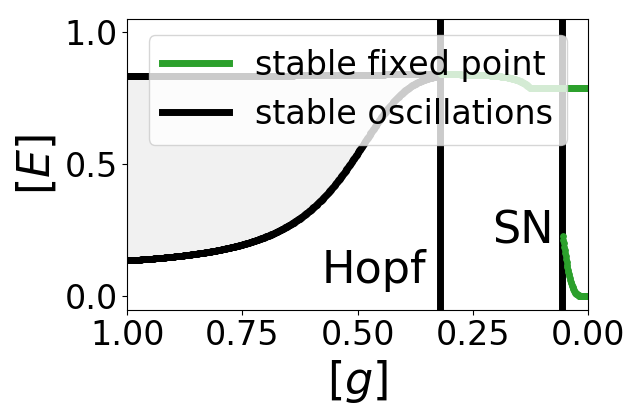

In [13]:
# Compute the positions of the stable fixed points and limit cycles
index_g_SN = 55
index_g_Hopf = 320

fp1 = np.amax(results_bif1[:,:,0], axis=1)[:index_g_SN]
fp2 = np.flipud(np.amax(results_bif2[:,:,0], axis=1))[:index_g_Hopf]

lc_max = np.flipud(np.amax(results_bif2[:,2000:,0], axis=1))[index_g_Hopf:]
lc_min = np.flipud(np.amin(results_bif2[:,2000:,0], axis=1))[index_g_Hopf:]

g_Hopf = g_array[index_g_Hopf]
g_SN = g_array[index_g_SN]


# Generate the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.2
fig, ax = plt.subplots()

# Bifurcation diagram
ax.fill_between(g_array[index_g_Hopf:], lc_min, lc_max, color='tab:grey', alpha=0.1)
ax.scatter(g_array[index_g_Hopf:], lc_max, s=15, color='k')
ax.scatter(g_array[index_g_Hopf:], lc_min, s=15, color='k')
ax.scatter(g_array[:index_g_SN], fp1, s=15, color='tab:green')
ax.scatter(g_array[:index_g_Hopf], fp2, s=15, color='tab:green')

# Identify the bifurcation events
ax.plot([g_Hopf, g_Hopf], [-0.05, 1.05], 'k', lw=5, zorder=0)
ax.text(g_Hopf+0.03, 0.05, 'Hopf', fontsize=32, horizontalalignment='right')
ax.plot([g_SN, g_SN], [-0.05, 1.05], 'k', lw=5, zorder=0)
ax.text(g_SN+0.02, 0.2, 'SN', fontsize=32, horizontalalignment='right')

# Legend
ax.plot([], [], lw=5, color='tab:green', label='stable fixed point')
ax.plot([], [], lw=5, color='k', label='stable oscillations')
ax.legend(loc=9, fontsize=24)
    
# Other plot options
ax.set_ylabel('$[E]$', fontsize=32)
ax.set_xlabel('$[g]$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-0.05, 1.05])
        
fig.tight_layout()
fig.show()

The stable limit cycle dies through a Hopf bifurcation. The stable fixed point that forms as a result of the bifurcation becomes one of the two stable fixed points that define the two regions of the pattern. The other stable fixed point forms after the Hopf bifurcation via a saddle-node bifurcation. Note that the unstable fixed point that forms during the saddle-node bifurcation is not shown here.

####      

**2.5 The period of the oscillations as a function of $g$**

In the following code cell, we compute and plot the period of oscillations as a function of the concentration of morphogen $g$.

<IPython.core.display.Javascript object>


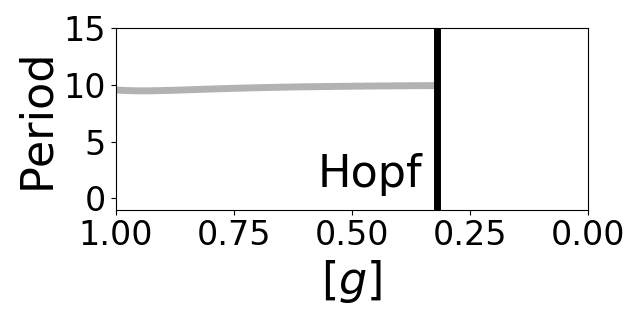

In [14]:
# Compute the period
period = np.zeros(len(g_array[index_g_Hopf:]))

for k in range(len(g_array[index_g_Hopf:])):
    
    counter = 0 
    
    if (results_bif2[k,-2,0] < results_bif2[k,-1,0]):
        
        for j in range(len(results_bif2[k,:,0])-3):
        
            if (results_bif2[k,-j-3,0] > results_bif2[k,-1,0]) and (counter==0):
                counter = 1
                
            elif (results_bif2[k,-j-3,0] < results_bif2[k,-1,0]) and (counter==1):
                counter = 2
                period[k] = (j+3)*param["dt"]
    
    
    elif (results_bif2[k,-2,0] > results_bif2[k,-1,0]):
        
        for j in range(len(results_bif2[index_g_Hopf+k,:,0])-3):
        
            if (results_bif2[k,-j-3,0] < results_bif2[k,-1,0]) and (counter==0):
                counter = 1
                
            elif (results_bif2[k,-j-3,0] > results_bif2[k,-1,0]) and (counter==1):
                counter = 2
                period[k] = (j+3)*param["dt"]
                
                
                
# Generate the plot of the period as a fonction of g
plt.rcParams["figure.figsize"] = 6.4, 3.2
fig, ax = plt.subplots()

# Period vs g
g = np.arange(0., 1.001, 0.001)
ax.plot(g_array[index_g_Hopf:], period, c='k', alpha=0.3, lw=5)

# Identify the Hopf bifurcation
ax.plot([g_Hopf, g_Hopf], [-1, 15], 'k', lw=5, zorder=0)
ax.text(g_Hopf+0.03, 1, 'Hopf', fontsize=32, horizontalalignment='right')

# Other plot options
ax.set_xlabel('[$g$]', fontsize=32)
ax.set_ylabel('Period', fontsize=32)
ax.set_xlim([1., 0.])
ax.set_ylim([-1., 15.])
ax.set_yticks([0., 5., 10., 15.])
ax.tick_params(labelsize=24)

fig.tight_layout()
fig.show()

Note that the oscillations die with a finite period during the Hopf bifurcation.

####     

**2.6 The bifurcation diagram as a function of time**

We plot the same bifurcation diagram as in section 2.4, but now with the $x$ axis representing time. For any given time $t^*$, we plot the position of the fixed points and of the extrema of the limit cycles _for the concentration of morphogen $g$ that is found in a given simulated cell at that time_ $t^*$. We pick cell #140, which is the first cell for which we plotted the trajectory in section 1.5.

<IPython.core.display.Javascript object>


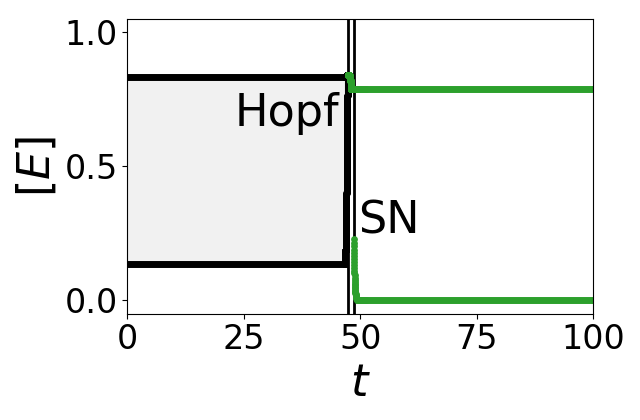

In [15]:
# Generate the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.2
fig, ax = plt.subplots()

# Bifurcation diagram
times = np.zeros(len(g_array)) -1.
times[1:] = compute_t(g_array[1:], 140., param)

ax.fill_between(times[index_g_Hopf:], lc_min, lc_max, color='tab:grey', alpha=0.1, zorder=10)
ax.scatter(times[index_g_Hopf:], lc_max, s=15, color='k', zorder=10)
ax.scatter(times[index_g_Hopf:], lc_min, s=15, color='k', zorder=10)
ax.scatter(times[:index_g_SN], fp1, s=15, color='tab:green', zorder=10)
ax.scatter(times[:index_g_Hopf], fp2, s=15, color='tab:green', zorder=10)

ax.fill_between([0., times[-1]], [lc_min[-1], lc_min[-1]], [lc_max[-1], lc_max[-1]], color='tab:grey', alpha=0.1, zorder=1)
ax.plot([0., times[-1]], [lc_min[-1], lc_min[-1]], color='k', lw=5, zorder=1)
ax.plot([0., times[-1]], [lc_max[-1], lc_max[-1]], color='k', lw=5, zorder=1)
ax.plot([times[1], np.max(times_plot)], [fp1[1], fp1[1]], color='tab:green', lw=5, zorder=1)
ax.plot([times[1], np.max(times_plot)], [fp2[1], fp2[1]], color='tab:green', lw=5, zorder=1)

# Identify the bifurcation events
ax.plot([times[index_g_Hopf], times[index_g_Hopf]], [-0.05, 1.05], 'k', lw=2, zorder=0)
ax.text(times[index_g_Hopf]-2., 0.65, 'Hopf', fontsize=32, horizontalalignment='right')
ax.plot([times[index_g_SN], times[index_g_SN]], [-0.05, 1.05], 'k', lw=2, zorder=0)
ax.text(times[index_g_SN]+1., 0.25, 'SN', fontsize=32, horizontalalignment='left')

# # Legend
# ax.plot([], [], lw=5, color='tab:green', label='stable fixed point')
# ax.plot([], [], lw=5, color='k', label='stable oscillations')
# ax.legend(loc=9, fontsize=24)
    
# Other plot options
ax.set_ylabel('$[E]$', fontsize=32)
ax.set_xlabel('$t$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([np.min(times_plot), np.max(times_plot)])
ax.set_ylim([-0.05, 1.05])
        
fig.tight_layout()
fig.show()